# 0. LIBRERIAS



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. CARGA DE DATASET

In [2]:
df1 = pd.read_excel('/content/df_2012_under.xlsx', index_col="timestamp")
df2 = pd.read_excel('/content/df_2014_under.xlsx', index_col="timestamp")
df3 = pd.read_excel('/content/df_2015_preproc_10s.xlsx', index_col="timestamp")

In [3]:
df_train = pd.concat([df1, df2], axis = 0)
df_test = df3

# 2.DATOS PARA ALGORITMO

In [4]:
# Datos
X_train = df_train.drop(columns=['class'])
y_train = df_train['class']
X_test = df_test.drop(columns=['class'])
y_test = df_test['class']

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, make_scorer

# 1. EXPERIMENTO BASE

In [6]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.7 MB/s eta 0:00:00


In [7]:
from skopt import BayesSearchCV

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, make_scorer
from skopt.space import Integer

rfc = RandomForestClassifier(random_state=1225)

param_space = {
        'n_estimators': Integer(10, 150),
        'max_depth': Integer(5, 50),
        'min_samples_split': Integer(2, 100),
    }

#param_space = {
#    'n_estimators': range(10, 200, 50),
#    'max_depth': range(2, 50, 10),
#    'min_samples_split': range(2, 100, 25),
#    }

# Define a custom score
def custom_score(y_true, y_pred):
  NN, NT, NF, TN, TT, TF, FN, FT, FF = confusion_matrix(y_true, y_pred, labels=["Normal", "Transitorio", "Falla"] ).ravel()

  c_score = 15 * TT -2*NT-2*FT #high is good
  return c_score

scorer = make_scorer(custom_score, greater_is_better=True)

rf_bayes = BayesSearchCV(
    estimator=rfc,
    search_spaces=param_space,
    n_jobs=1,
    cv=5,
    n_iter=30,
    scoring=scorer,
    verbose=4,
    random_state=1225
)

rf_bayes.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=47, min_samples_split=13, n_estimators=31;, score=42375.000 total time=   2.2s
[CV 2/5] END max_depth=47, min_samples_split=13, n_estimators=31;, score=43095.000 total time=   2.0s
[CV 3/5] END max_depth=47, min_samples_split=13, n_estimators=31;, score=43104.000 total time=   2.2s
[CV 4/5] END max_depth=47, min_samples_split=13, n_estimators=31;, score=30227.000 total time=   2.6s
[CV 5/5] END max_depth=47, min_samples_split=13, n_estimators=31;, score=15548.000 total time=   3.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=43, min_samples_split=40, n_estimators=39;, score=42393.000 total time=   3.7s
[CV 2/5] END max_depth=43, min_samples_split=40, n_estimators=39;, score=43110.000 total time=   3.0s
[CV 3/5] END max_depth=43, min_samples_split=40, n_estimators=39;, score=43110.000 total time=   1.8s
[CV 4/5] END max_depth=43, min_samples_split=40, n_estimators=39;,

BayesSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1225),
              n_iter=30, random_state=1225,
              scoring=make_scorer(custom_score, response_method='predict'),
              search_spaces={'max_depth': Integer(low=5, high=50, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=100, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=10, high=150, prior='uniform', transform='normalize')},
              verbose=4)

In [9]:
best_params = rf_bayes.best_params_
print(best_params)

OrderedDict({'max_depth': 39, 'min_samples_split': 98, 'n_estimators': 76})


In [10]:
rfc = RandomForestClassifier(**best_params, random_state=1225)

In [11]:
rfc.fit(X_train, y_train)

y_pred_test= rfc.predict(X_test)
y_pred_train= rfc.predict(X_train)

In [12]:
importance = rfc.feature_importances_

In [13]:
feature_scores = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

,0
P-PDG,0.315412
P-TPT,0.227807
T-PDG,0.144728
T-TPT,0.140827
T-MON-CKP,0.064927
P-MON-CKP,0.058934
P-JUS-CKP,0.047366


In [14]:
#Métricas en train

y_true = y_train
y_pred = y_pred_train

def custom_score(y_true, y_pred):
  NN, NT, NF, TN, TT, TF, FN, FT, FF = confusion_matrix(y_true, y_pred, labels=["Normal", "Transitorio", "Falla"] ).ravel()

  gan = 15*TT -2*NT-2*FT #high is good

  F1_T = (2*TT) / (2*TT + NT + FT + TN + TF) # F1-score p transitorio
  Acc = (NN+TT+FF)/(NN+NT+NF+TN+TT+TF+FN+FT+FF) # Accuracy global

  FPR = (NT+FT) / (NN+NT+NF+FN+FT+FF) # False Positive Rate

  Prec_T = TT / (NT + TT + FT) #Precision

  Recall_T = TT / (TN + TT + TF) #Recall

  return gan, F1_T, Acc, FPR, Prec_T, Recall_T

gan, F1_T, Acc, FPR, Prec_T, Recall_T = custom_score(y_true, y_pred)
print("Ganancia: ", gan)
print("F1_score_transitorio: ", round(F1_T,5))
print("Accuracy: ", round(Acc,5))
print("FPR: ", round(FPR,5))
print("Precision: ", round(Prec_T,5))
print("Recall: ", round(Recall_T,5))

Ganancia:  215556
F1_score_transitorio:  0.99955
Accuracy:  0.99959
FPR:  0.0007
Precision:  0.99917
Recall:  0.99993


In [15]:
#Métricas en test
y_true = y_test
y_pred = y_pred_test

def custom_score(y_true, y_pred):
  NN, NT, NF, TN, TT, TF, FN, FT, FF = confusion_matrix(y_true, y_pred, labels=["Normal", "Transitorio", "Falla"] ).ravel()

  gan = 15*TT -2*NT-2*FT #high is good

  F1_T = (2*TT) / (2*TT + NT + FT + TN + TF) # F1-score p transitorio
  Acc = (NN+TT+FF)/(NN+NT+NF+TN+TT+TF+FN+FT+FF) # Accuracy global

  FPR = (NT+FT) / (NN+NT+NF+FN+FT+FF) # False Positive Rate

  Prec_T = TT / (NT + TT + FT) #Precision

  Recall_T = TT / (TN + TT + TF) #Recall

  return gan, F1_T, Acc, FPR, Prec_T, Recall_T

gan, F1_T, Acc, FPR, Prec_T, Recall_T = custom_score(y_true, y_pred)
print("Ganancia: ", gan)
print("F1_score_transitorio: ", round(F1_T,5))
print("Accuracy: ", round(Acc,5))
print("FPR: ", round(FPR,5))
print("Precision: ", round(Prec_T,5))
print("Recall: ", round(Recall_T,5))

Ganancia:  155673
F1_score_transitorio:  0.88279
Accuracy:  0.82629
FPR:  0.4824
Precision:  0.80307
Recall:  0.98009


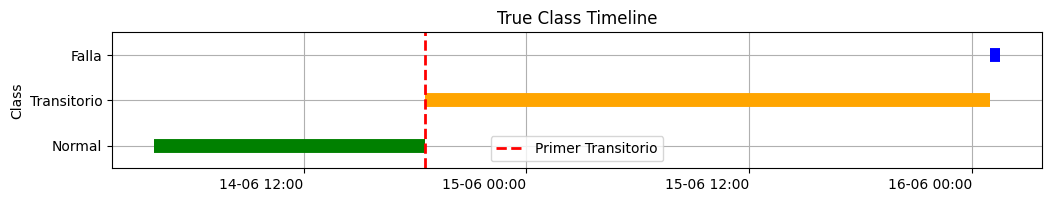

In [16]:
#timeline in true test
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import dates as mdates # Import mdates for date formatting

# Map categorical labels to numerical values
y_test_series = pd.Series(y_test, index=y_test.index)
y_num = y_test_series.map({'Normal': 0, 'Transitorio': 1, 'Falla': 2})

# Identify where the class changes
class_changes = y_num[y_num.diff() != 0]

# Create segments
segments = []
if not class_changes.empty:
    # First segment starts at the beginning of the series
    segments.append({'start': y_num.index[0], 'end': class_changes.index[0], 'class': y_num.iloc[0]})

    # Intermediate segments
    for i in range(len(class_changes) - 1):
        segments.append({
            'start': class_changes.index[i],
            'end': class_changes.index[i+1],
            'class': class_changes.iloc[i]
        })

    # Last segment starts at the last change point and ends at the end of the series
    segments.append({'start': class_changes.index[-1], 'end': y_num.index[-1], 'class': class_changes.iloc[-1]})
else:
    # If no class changes, the whole series is one segment
    if not y_num.empty:
        segments.append({'start': y_num.index[0], 'end': y_num.index[-1], 'class': y_num.iloc[0]})


fig, ax = plt.subplots(figsize=(12, 2)) # Adjust figure size as needed

# Define y-axis positions and colors for each class
y_positions = {0: 0, 1: 1, 2: 2}
class_colors = {0: 'green', 1: 'orange', 2: 'blue'} # Define colors for clarity
class_labels = {0: 'Normal', 1: 'Transitorio', 2: 'Falla'} # Define labels for legend

# Plot horizontal lines for each segment
for segment in segments:
    start_time = segment['start']
    end_time = segment['end']
    class_value = segment['class']
    y_pos = y_positions[class_value]
    color = class_colors[class_value]
    label = class_labels[class_value]

    # Plot a horizontal line for the segment
    ax.hlines(y_pos, start_time, end_time, color=color, lw=10) #lw line widht


first_transitorio_test = y_test[y_test == 'Transitorio'].index[0]
ax.axvline(x=first_transitorio_test, color='red', linestyle='--', linewidth=2, label = 'Primer Transitorio')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
#ax.set_xticklabels(ticklabels, fontsize=8);

ax.set_ylabel("Class")
ax.set_title("True Class Timeline")

# Set y-axis ticks and labels
ax.set_yticks([y_positions[0], y_positions[1], y_positions[2]])
ax.set_yticklabels(["Normal", "Transitorio", "Falla"])
ax.set_ylim(-0.5,2.5)

# Improve x-axis tick formatting for dates
fig.autofmt_xdate() # Auto-format date labels for better readability

# Add a legend - ensure unique labels are used for the legend
handles, labels = ax.get_legend_handles_labels()
# Create a dictionary to store unique handles and labels
unique_labels = dict(zip(labels, handles))

plt.legend(loc = 'lower center')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

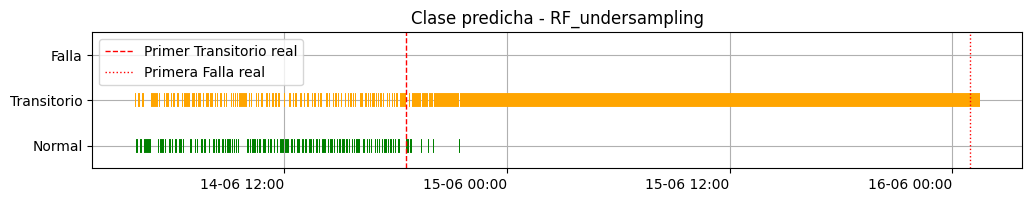

In [17]:
#timeline in predicted test
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import dates as mdates # Import mdates for date formatting

# Map categorical labels to numerical values
y_pred_test_series = pd.Series(y_pred_test, index=y_test.index)
y_num = y_pred_test_series.map({'Normal': 0, 'Transitorio': 1, 'Falla': 2})

# Identify where the class changes
class_changes = y_num[y_num.diff() != 0]

# Create segments
segments = []
if not class_changes.empty:
    # First segment starts at the beginning of the series
    segments.append({'start': y_num.index[0], 'end': class_changes.index[0], 'class': y_num.iloc[0]})

    # Intermediate segments
    for i in range(len(class_changes) - 1):
        segments.append({
            'start': class_changes.index[i],
            'end': class_changes.index[i+1],
            'class': class_changes.iloc[i]
        })

    # Last segment starts at the last change point and ends at the end of the series
    segments.append({'start': class_changes.index[-1], 'end': y_num.index[-1], 'class': class_changes.iloc[-1]})
else:
    # If no class changes, the whole series is one segment
    if not y_num.empty:
        segments.append({'start': y_num.index[0], 'end': y_num.index[-1], 'class': y_num.iloc[0]})


fig, ax = plt.subplots(figsize=(12, 2)) # Adjust figure size as needed

# Define y-axis positions and colors for each class
y_positions = {0: 0, 1: 1, 2: 2}
class_colors = {0: 'green', 1: 'orange', 2: 'blue'} # Define colors for clarity
class_labels = {0: 'Normal', 1: 'Transitorio', 2: 'Falla'} # Define labels for legend

# Plot horizontal lines for each segment
for segment in segments:
    start_time = segment['start']
    end_time = segment['end']
    class_value = segment['class']
    y_pos = y_positions[class_value]
    color = class_colors[class_value]
    label = class_labels[class_value]

    # Plot a horizontal line for the segment
    ax.hlines(y_pos, start_time, end_time, color=color, lw=10) #lw line widht

first_transitorio_test = y_test[y_test == 'Transitorio'].index[0]
first_falla_test = y_test[y_test == 'Falla'].index[0]
ax.axvline(x=first_transitorio_test, color='red', linestyle='--', linewidth=1, label = 'Primer Transitorio real')

ax.axvline(x=first_falla_test, color='red', linestyle='dotted', linewidth=1, label = 'Primera Falla real')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
#ax.set_xticklabels(ticklabels, fontsize=8);

#ax.set_ylabel("Class")
ax.set_title("Clase predicha - RF_undersampling")

# Set y-axis ticks and labels
ax.set_yticks([y_positions[0], y_positions[1], y_positions[2]])
ax.set_yticklabels(["Normal", "Transitorio", "Falla"])
ax.set_ylim(-0.5,2.5)

# Improve x-axis tick formatting for dates
fig.autofmt_xdate() # Auto-format date labels for better readability

# Add a legend - ensure unique labels are used for the legend
handles, labels = ax.get_legend_handles_labels()
# Create a dictionary to store unique handles and labels
unique_labels = dict(zip(labels, handles))

plt.legend(loc = 'upper left')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

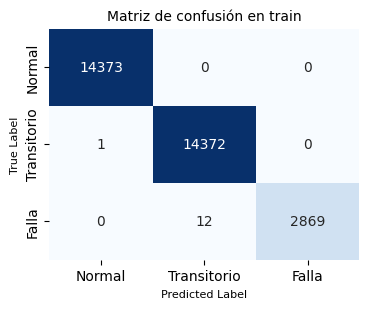

In [18]:
#Matriz de confusion con train
import seaborn as sns
import matplotlib.pyplot as plt

y_true = y_train
y_pred = y_pred_train
cm = confusion_matrix(y_true, y_pred, labels=["Normal", "Transitorio", "Falla"])

# heatmap
plt.figure(figsize=(4, 3)) # Optional: Adjust figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Transitorio', 'Falla'],
            yticklabels=['Normal', 'Transitorio', 'Falla'])
plt.xlabel('Predicted Label', fontsize = 8)
plt.ylabel('True Label', fontsize = 8)
plt.title('Matriz de confusión en train', fontsize = 10)
plt.show()

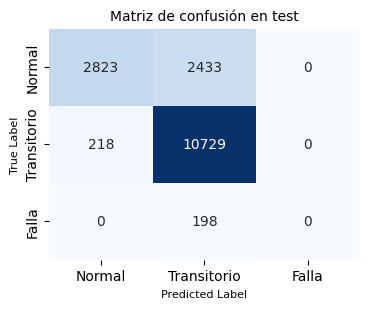

In [19]:
#Matriz de confusion con test
import seaborn as sns
import matplotlib.pyplot as plt

y_true = y_test
y_pred = y_pred_test
cm = confusion_matrix(y_true, y_pred, labels=["Normal", "Transitorio", "Falla"])

# heatmap
plt.figure(figsize=(4, 3)) # Optional: Adjust figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Transitorio', 'Falla'],
            yticklabels=['Normal', 'Transitorio', 'Falla'])
plt.xlabel('Predicted Label', fontsize = 8)
plt.ylabel('True Label', fontsize = 8)
plt.title('Matriz de confusión en test', fontsize = 10)
plt.show()

In [20]:
#FIRST TRANSITORIO REAL (iN test)
mask = (y_test == "Transitorio")
#y_test_series = pd.Series(y_test, index=y_test.index)
first_transitorio_test = (y_test[mask].first_valid_index())
print(first_transitorio_test)
#first_transitorio_test = y_test[y_test == 'Transitorio'].index[0]

2015-06-14 18:33:10


In [21]:
#FIRST TRANSITORIO PREDICHO (test_pred)
mask2 = (y_pred_test == "Transitorio")
# Convert y_pred_train to a pandas Series with the same index as y_train
y_pred_test_series = pd.Series(y_pred_test, index=y_test.index)
print(y_pred_test_series[mask2].first_valid_index())

2015-06-14 03:57:50


In [22]:
#FIRST TRUE TRANSITORIO PREDICHO (PARA TEST)
mask = (y_pred_test_series == 'Transitorio') & (y_test== 'Transitorio')
first_true_pred_transitorio_test = y_pred_test_series[mask].first_valid_index()
print(first_true_pred_transitorio_test)

2015-06-14 18:33:10
